# 预测房价

## 下载和缓存数据集

In [14]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [15]:
import os
import hashlib
import requests

def download(name, cache_dir=os.path.join('..', 'data')):  # @save
    """
    下载一个DATA_HUB中的文件，返回本地文件名。

    参数:
    - name: 数据名称，必须是DATA_HUB中的键。
    - cache_dir: 缓存目录，默认为'../data'。

    返回:
    - fname: 下载文件的本地路径。
    """
    # 检查name是否在DATA_HUB中
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    
    # 从DATA_HUB中获取文件的URL和SHA-1哈希值
    url, sha1_hash = DATA_HUB[name]
    
    # 创建缓存目录（如果不存在）
    os.makedirs(cache_dir, exist_ok=True)
    
    # 构造本地文件名（使用URL中的文件名）
    fname = os.path.join(cache_dir, url.split('/')[-1])
    
    # 检查文件是否已经存在
    if os.path.exists(fname):
        # 计算文件的SHA-1哈希值
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)  # 每次读取1MB
                if not data:
                    break
                sha1.update(data)
        
        # 如果文件的哈希值与预期一致，则直接返回文件名（命中缓存）
        if sha1.hexdigest() == sha1_hash:
            return fname
    
    # 如果文件不存在或哈希值不匹配，则下载文件
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    
    # 返回下载文件的本地路径
    return fname

In [16]:
def download_extract(name, folder=None):  # @save
    """下载并解压zip/tar文件"""
    # 调用 download 函数下载文件，返回本地文件路径
    fname = download(name)
    
    # 获取文件所在目录
    base_dir = os.path.dirname(fname)
    
    # 获取文件路径（不含扩展名）和扩展名
    data_dir, ext = os.path.splitext(fname)
    
    # 根据文件扩展名选择解压方式
    if ext == '.zip':
        # 如果是 zip 文件，使用 zipfile 解压
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        # 如果是 tar 或 gz 文件，使用 tarfile 解压
        fp = tarfile.open(fname, 'r')
    else:
        # 如果不是 zip/tar 文件，抛出异常
        assert False, '只有zip/tar文件可以被解压缩'
    
    # 解压文件到 base_dir
    fp.extractall(base_dir)
    
    # 返回解压后的文件夹路径
    return os.path.join(base_dir, folder) if folder else data_dir



def download_all():  # @save
    """下载DATA_HUB中的所有文件"""
    # 遍历 DATA_HUB 中的所有数据名称
    for name in DATA_HUB:
        # 调用 download 函数下载文件
        download(name)

## 访问和读取数据集

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [18]:
DATA_HUB['kaggle_house_train'] = ( #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [19]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

训练数据集包括1460个样本，每个样本80个特征和1个标签，而测试数据集包含1459个样本，每个样本80个特
征

In [20]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


让我们看看前四个和最后两个特征，以及相应标签（房价）。

In [21]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


第一个特征是ID，这有助于模型识别每个训练样本。虽然这很方便，但它不携带任何用于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [30]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 数据预处理

首先，我们将所有缺失的值替换为相应特征的平均值。然后，为了将所有特征放在一个共同的尺度上，我们通过将特征重新缩放到零均值和单位方差来标准化数据

In [31]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
# 选择所有数值型特征的列名
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 对数值型特征进行标准化处理
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来，我们处理离散值特征，例如“MSZoning”。我们采用独热编码（One-Hot Encoding）将其转换为二进制向量。以“MSZoning”为例，假设它包含“RL”和“Rm”两个类别，我们会创建两个新的二进制特征“MSZoning_RL”和“MSZoning_RM”。如果原始值为“RL”，则“MSZoning_RL”为1，“MSZoning_RM”为0；反之亦然。Pandas 提供了 `get_dummies` 函数，能够自动完成这一转换，将离散值特征扩展为适合模型处理的二进制特征。

In [33]:

# 对 all_features 中的所有离散值特征进行独热编码，并将缺失值（NaN）视为有效特征值
all_features = pd.get_dummies(all_features, dummy_na=True)

# 输出处理后的 DataFrame 的形状
all_features.shape

(2919, 330)

到此转换会将特征的总数量从79个增加到331个。最后，通过values属性，我们可以从pandas格式中提
取NumPy格式，并将其转换为张量表示用于训练。

In [40]:
# 获取训练数据的行数（样本数量）
n_train = train_data.shape[0]

# 清理数据
# 1. 填充缺失值：将所有缺失值（NaN）填充为 0
all_features = all_features.fillna(0)

# 2. 强制转换数据类型：将所有列的数据类型转换为 float，确保数据一致性
all_features = all_features.astype(float)

# 将训练数据部分转换为 PyTorch 张量
# all_features[:n_train] 选择训练数据部分，.values 将 Pandas DataFrame 转换为 NumPy 数组
# torch.tensor 将 NumPy 数组转换为 PyTorch 张量，并指定数据类型为 torch.float32
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)

# 将测试数据部分转换为 PyTorch 张量
# all_features[n_train:] 选择测试数据部分，.values 将 Pandas DataFrame 转换为 NumPy 数组
# torch.tensor 将 NumPy 数组转换为 PyTorch 张量，并指定数据类型为 torch.float32
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

# 将训练数据的标签（SalePrice）转换为 PyTorch 张量
# train_data.SalePrice.values 获取标签列并转换为 NumPy 数组
# .reshape(-1, 1) 将一维数组转换为二维数组，形状为 (n_train, 1)
# torch.tensor 将 NumPy 数组转换为 PyTorch 张量，并指定数据类型为 torch.float32
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32
)

## 开始训练

In [41]:
# 定义均方误差损失函数
loss = nn.MSELoss()

# 获取输入特征的维度（特征数量）
in_features = train_features.shape[1]

# 定义一个函数，用于创建神经网络模型
def get_net():
    # 使用 nn.Sequential 定义一个简单的线性回归模型
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [42]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    
    # 计算对数均方根误差
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    
    # 返回 RMSE 的值（标量）
    return rmse.item()

这里训练函数将借助Adam优化器。Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [43]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # 初始化训练和测试的 Log-RMSE 列表
    train_ls, test_ls = [], []
    
    # 将训练数据转换为 DataLoader，方便按批次加载数据
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    # 使用 Adam 优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)
    
    # 训练循环
    for epoch in range(num_epochs):
        # 遍历每个批次
        for X, y in train_iter:
            # 梯度清零
            optimizer.zero_grad()
            
            # 前向传播：计算预测值
            l = loss(net(X), y)
            
            # 反向传播：计算梯度
            l.backward()
            
            # 更新模型参数
            optimizer.step()
        
        # 计算当前 epoch 的训练集 Log-RMSE
        train_ls.append(log_rmse(net, train_features, train_labels))
        
        # 如果提供了测试数据，计算当前 epoch 的测试集 Log-RMSE
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    
    # 返回训练和测试的 Log-RMSE 列表
    return train_ls, test_ls

## K折交叉验证

In [44]:
def get_k_fold_data(k, i, X, y):
    # 确保 k 大于 1
    assert k > 1
    
    # 计算每折的大小
    fold_size = X.shape[0] // k
    
    # 初始化训练集和验证集
    X_train, y_train = None, None
    
    # 遍历每一折
    for j in range(k):
        # 获取当前折的索引范围
        idx = slice(j * fold_size, (j + 1) * fold_size)
        
        # 提取当前折的数据
        X_part, y_part = X[idx, :], y[idx]
        
        # 如果当前折是第 i 折，则作为验证集
        if j == i:
            X_valid, y_valid = X_part, y_part
        # 如果训练集为空，则将当前折作为训练集
        elif X_train is None:
            X_train, y_train = X_part, y_part
        # 否则，将当前折拼接到训练集中
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    
    # 返回训练集和验证集
    return X_train, y_train, X_valid, y_valid

当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [45]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    # 初始化训练和验证的 Log-RMSE 总和
    train_l_sum, valid_l_sum = 0, 0
    
    # 遍历每一折
    for i in range(k):
        # 获取当前折的训练集和验证集
        data = get_k_fold_data(k, i, X_train, y_train)
        
        # 初始化模型
        net = get_net()
        
        # 训练模型，并获取训练和验证的 Log-RMSE
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        
        # 累加当前折的训练和验证 Log-RMSE
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        # 如果是第一折，绘制训练和验证的 Log-RMSE 曲线
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        
        # 打印当前折的训练和验证 Log-RMSE
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    
    # 返回训练和验证的平均 Log-RMSE
    return train_l_sum / k, valid_l_sum / k

## 模型选择

折1，训练log rmse0.170334, 验证log rmse0.157083
折2，训练log rmse0.162344, 验证log rmse0.189655
折3，训练log rmse0.163357, 验证log rmse0.168360
折4，训练log rmse0.167718, 验证log rmse0.154464
折5，训练log rmse0.162935, 验证log rmse0.182733
5-折验证: 平均训练log rmse: 0.165338, 平均验证log rmse: 0.170459


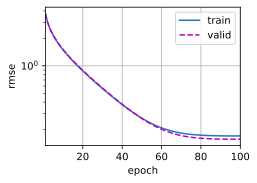

In [46]:
# 设置超参数
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64

# 进行 K 折交叉验证
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

# 打印平均训练和验证的 Log-RMSE
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')